# KCAP module demonstration

## Setup
Import the usual suspects.

In [1]:
import os
import numpy as np
import scipy.interpolate

%matplotlib inline
import matplotlib.pyplot as plt

pi = np.pi

KCAP isn't a proper package yet, so we can't import it directly and have to add it to the path manually for now.

In [2]:
import importlib

import sys
sys.path.append("..")
import kcap.twopoint
import kcap.cosmosis_utils

Set paths to the CSL and cosebis directories. Once everything is properly merged into kcap that won't be necessary anymore but for now this setup makes development easier.

In [3]:
# csl_path = "../../cosmosis-standard-library/"
# cosebis_path = "../../cosebis/"
# boss_path = "../../kcap_boss_module/python_interface/"

csl_path = "../cosmosis-standard-library"
cosebis_path = "../cosebis/"
boss_path = "../../kcap_boss_module/python_interface/"

# Test P_gm interpolation

Run this to reload modules.

In [7]:
importlib.reload(kcap.cosmosis_utils)
importlib.reload(kcap.twopoint)

sys.modules.pop("cosmosis_module", None)
sys.modules.pop("bias_module", None)
sys.modules.pop("hmx_module", None)
sys.modules.pop("halofit_module", None)
sys.modules.pop("project_2d", None)
sys.modules.pop("limber", None)
sys.modules.pop("galaxy_bias", None)

In [8]:
nofz = {"shear" : ["../data/KV450/nofz/Nz_DIR_z0.7t0.9.asc",
                    ],
       "galaxy" : ["../data/BOSS/nofz/nOfZ_hist_BOSSA_tomo0.dat", 
                   "../data/BOSS/nofz/nOfZ_hist_BOSSA_tomo1.dat",],
        }

twopoint = {}
cls = {}

window_file = os.path.join(boss_path, "../CosmoMC_BOSS/data/BOSS.DR12_windows.txt")
bands_file = os.path.join(boss_path, "../CosmoMC_BOSS/data/BOSS.DR12_rbands.txt")

cosmological_parameters = {#"omega_b" : 4.8246962797075028e-2,
                           #"omega_c" : 0.25731178759694234,
                           "ombh2" : 0.2228089E-01,
                           "omch2" : 0.1181838E+00,
                           "h0"    : 0.679565,
                           "A_s"   : 2.170229e-9,
                           "n_s"   : 0.9679701,
                           "tau"    : 0.0739,
#                            "omnuh2" : 6.4514389153979819e-4,
                            "omega_nu" : 6.4514389153979819e-4/0.679565**2,
                           "massive_nu" : 1,
                           "massless_nu" : 2.046,
                          }


bias_parameters = {# Best fit values of BOSS+Planck LCDM chain
                   "b1_bin_1" : 1.8871010,
                   "b2_bin_1" : -0.11710970,
                   "gamma3_bin_1" : 0.79485430,
                   "a_vir_bin_1" : 3.7555320,
                  
                   "b1_bin_2" : 2.0381540,
                   "b2_bin_2" : -0.32735810,
                   "gamma3_bin_2" : 0.56583030,
                   "a_vir_bin_2" : 3.4798580,
                   
                   # Linear bias
                   "b1" : 2.0381540,
                }

# Default parameters from Ariel
# bias_parameters = {"gamma" : 0.47,
                   
#                    "b1_bin_1" : 1.912671,
#                    "b2_bin_1" : 0.01982811,
#                    "gamma2_bin_1" : 1.9,
#                    "gamma3_bin_1" : 0.9722212,
#                    "a_vir_bin_1" : 3.884050,
                  
#                    "b1_bin_2" : 2.069093,
#                    "b2_bin_2" : -0.08266389,
#                    "gamma2_bin_2" : 1.0,
#                    "gamma3_bin_2" : 1.049944,
#                    "a_vir_bin_2" : 3.414406,
#                 }



# Compute ggl signal for different combinations of galaxy-matter power spectra
# and interpolation schemes.
#
# mode:
# 'pk_gm' : use the BOSS P_gm directly
# 'bias' : calculate the bias from BOSS as P_gm/P_mm and apply it to a 
#          non-linear matter power spectrum.
# 'linear_bias' : use linear bias with nonlinear matter power spectrum.
#
# z_interpolation:
# 'none' : don't interpolate or extrapolate in redshift. Use constant P_gm 
#          (for mode 'pk_gm') or constant bias (for mode 'bias') over BOSS bin.
# 'const' : don't interpolate in redshift. Use constant P_gm 
#          (for mode 'pk_gm') or constant bias (for mode 'bias') over BOSS bin.
#           Extrapolate constant to z=0 and z=infinity.
# 'lin' :  use linear inter- and extrapolation in redshift. 
#
# k_interpolation: Analogous to z_interpolation.

for mode, z_interpolation, k_interpolation in [("pk_gm", "none", "none"), 
                                               ("pk_gm", "const", "none"),
                                               ("pk_gm", "lin", "none"),
                                               ("bias", "none", "none"),
                                               ("bias", "none", "const"),
                                               ("bias", "const", "const"),
                                               ("linear_bias", "none", "none"),
                                               ]:
    label = f"{mode}_{z_interpolation}_{k_interpolation}"
    twopoint[label] = kcap.twopoint.TwoPoint(
                          probes=           {"cl"                      : [("galaxy", "shear")],},
                          parameters=       {"cosmological_parameters" : cosmological_parameters,
                                             "bias_parameters"         : bias_parameters},
                          transfer_function="camb",
                          nonlinear_Pk=     "halofit",
                          nofz_files=       nofz,
                          module_paths=     {"CSL_PATH"                : csl_path,
                                             "BOSS_PATH"               : boss_path,
                                            },
                          module_configs=   {"camb" :                   {"k_eta_max_scalar"  : 1000,
                                                                         "high_accuracy_default" : "T",
                                                                         "accuracy_boost" : 1.0,
                                                                         "kmin"  : 1e-5,
                                                                         "kmax"  : 8.0,
                                                                         "nk"    : 200,
                                                                         "mode"  : "transfer",
                                                                         "zmax" : 6.0,
                                                                         "nz"   : 300,
                                                                         "background_zmax" : 6.0,
                                                                         "background_nz"   : 6000,},
                                             "halofit" :                {"nk" : 200},
                                             "boss" :                   {"window_file" : window_file,
                                                                         "bands_file"  : bands_file,
                                                                         "z_eff"       : [0.38, 0.61],
                                                                         "verbose"     : False,
                                                                         "bands_range" : "20 160",
                                                                         "points_range": "4 32"},
                                             "galaxy_bias" :            {"mode" : mode,
                                                                         "z_interpolation" : z_interpolation,
                                                                         "k_interpolation" : k_interpolation,
                                                                         "n_bin" : 2,
                                                                         "z_range_bin_1" : "0.2 0.5",
                                                                         "z_range_bin_2" : "0.5 0.75",
                                                                        },
                                             },
                          verbose=2,
                                          )
    
    ini = twopoint[label].get_pipeline_config()
    
    cl, ell, bin_names = twopoint[label].angular_power_spectrum(probes=("galaxy", "shear"), return_bin_names=True)
    cls[label] = cl

COSMOSIS_SRC_DIR. Module paths assumed to be relative
to current directory,  /Users/yooken/Research/KiDS/kcap/notebooks

Parameter Priors
----------------
cosmological_parameters--ombh2        ~ delta(0.02228089)
cosmological_parameters--omch2        ~ delta(0.1181838)
cosmological_parameters--h0           ~ delta(0.679565)
cosmological_parameters--a_s          ~ delta(2.170229e-09)
cosmological_parameters--n_s          ~ delta(0.9679701)
cosmological_parameters--tau          ~ delta(0.0739)
cosmological_parameters--omega_nu     ~ delta(0.0013969941369485325)
cosmological_parameters--massive_nu   ~ delta(1)
cosmological_parameters--massless_nu  ~ delta(2.046)
bias_parameters--b1_bin_1             ~ delta(1.887101)
bias_parameters--b2_bin_1             ~ delta(-0.1171097)
bias_parameters--gamma3_bin_1         ~ delta(0.7948543)
bias_parameters--a_vir_bin_1          ~ delta(3.755532)
bias_parameters--b1_bin_2             ~ delta(2.038154)
bias_parameters--b2_bin_2             ~ delta(-0.

camb took: 2.050 seconds
halofit took: 0.570 seconds
load_nofz_galaxy took: 0.001 seconds
load_nofz_shear took: 0.000 seconds
boss took: 18.732 seconds
galaxy_bias took: 0.008 seconds
Loading kernel N_galaxy
Computing spectrum: PositionShear -> galaxy_shear_cl


/Users/yooken/Research/KiDS/kcap/notebooks/../utils/galaxy_bias.py:75: RuntimeWarning: divide by zero encountered in true_divide
  bias = p_k_gm/p_k_mm
/Users/yooken/Research/KiDS/kcap/notebooks/../utils/galaxy_bias.py:75: RuntimeWarning: invalid value encountered in true_divide
  bias = p_k_gm/p_k_mm


projection took: 0.619 seconds
Total pipeline time: 22.1 seconds
Pipeline ran okay.
COSMOSIS_SRC_DIR. Module paths assumed to be relative
to current directory,  /Users/yooken/Research/KiDS/kcap/notebooks

Parameter Priors
----------------
cosmological_parameters--ombh2        ~ delta(0.02228089)
cosmological_parameters--omch2        ~ delta(0.1181838)
cosmological_parameters--h0           ~ delta(0.679565)
cosmological_parameters--a_s          ~ delta(2.170229e-09)
cosmological_parameters--n_s          ~ delta(0.9679701)
cosmological_parameters--tau          ~ delta(0.0739)
cosmological_parameters--omega_nu     ~ delta(0.0013969941369485325)
cosmological_parameters--massive_nu   ~ delta(1)
cosmological_parameters--massless_nu  ~ delta(2.046)
bias_parameters--b1_bin_1             ~ delta(1.887101)
bias_parameters--b2_bin_1             ~ delta(-0.1171097)
bias_parameters--gamma3_bin_1         ~ delta(0.7948543)
bias_parameters--a_vir_bin_1          ~ delta(3.755532)
bias_parameters--b1_b

/Users/yooken/Codes/miniconda/envs/test_cosmosis/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/yooken/Codes/miniconda/envs/test_cosmosis/lib/python3.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/yooken/Codes/miniconda/envs/test_cosmosis/lib/python3.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in sqrt
/Users/yooken/Codes/miniconda/envs/test_cosmosis/lib/python3.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide


Text(0,0.5,'Bias')

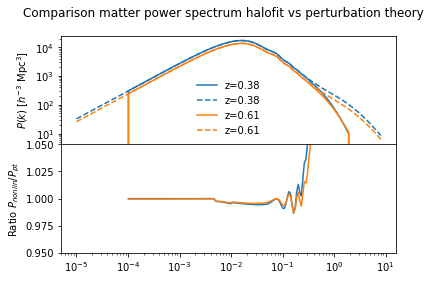

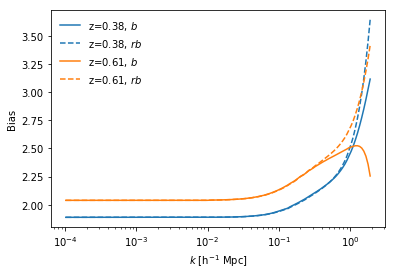

In [9]:
def pofk_interpolator(pofk, k, z=None):
    if z is None:
        intp = scipy.interpolate.InterpolatedUnivariateSpline(np.log(k), np.log(pofk))
        return lambda k: np.exp(intp(np.log(k))).squeeze()
    else:
        intp = scipy.interpolate.RectBivariateSpline(z, np.log(k), np.log(pofk))
        return lambda k, z: np.exp(intp(z, np.log(k), grid=True)).squeeze()

fig, ax = plt.subplots(2, 1, sharex=True, squeeze=False)
fig.subplots_adjust(hspace=0)

label = "pk_gm_none_none"
z = twopoint[label].data["matter_matter_power_spectrum_pt", "z"]
k = twopoint[label].data["matter_matter_power_spectrum_pt", "k_h"]
p_k_mm = twopoint[label].data["matter_matter_power_spectrum_pt", "p_k"]
p_k_gm = twopoint[label].data["galaxy_matter_power_spectrum_pt", "p_k"]

p_k_mm_nonlin = pofk_interpolator(twopoint[label].data["matter_power_nl", "p_k"], twopoint[label].data["matter_power_nl", "k_h"], twopoint[label].data["matter_power_nl", "z"])(k, z)

for i in range(len(z)):
    ax[0,0].loglog(k, p_k_mm[i], c=f"C{i}", label=f"z={z[i]}")
    ax[0,0].loglog(k, p_k_mm_nonlin[i], c=f"C{i}", ls="--", label=f"z={z[i]}")
    ax[1,0].semilogx(k, (p_k_mm_nonlin/p_k_mm)[i], c=f"C{i}", label=f"z={z[i]}")

ax[1,0].set_ylim(0.95, 1.05)
ax[0,0].legend(frameon=False)
ax[0,0].set_xlabel("$k$ [h$^{-1}$ Mpc]")
ax[0,0].set_ylabel("$P(k)$ [$h^{-3}$ Mpc$^{3}$]")
ax[1,0].set_ylabel("Ratio $P_{nonlin}/P_{pt}$")
fig.suptitle("Comparison matter power spectrum halofit vs perturbation theory")


fig, ax = plt.subplots(1, 1, squeeze=False)

label = "pk_gm_none_none"
z = twopoint[label].data["matter_matter_power_spectrum_pt", "z"]
k = twopoint[label].data["matter_matter_power_spectrum_pt", "k_h"]
p_k_mm = twopoint[label].data["matter_matter_power_spectrum_pt", "p_k"]
p_k_gm = twopoint[label].data["galaxy_matter_power_spectrum_pt", "p_k"]
p_k_gg = twopoint[label].data["galaxy_galaxy_power_spectrum_pt", "p_k"]

for i in range(len(z)):
    ax[0,0].semilogx(k, np.sqrt(p_k_gg/p_k_mm)[i], c=f"C{i}", label=f"z={z[i]}, $b$")
    ax[0,0].semilogx(k, (p_k_gm/p_k_mm)[i], c=f"C{i}", ls="--", label=f"z={z[i]}, $rb$")

ax[0,0].legend(frameon=False)
ax[0,0].set_xlabel("$k$ [h$^{-1}$ Mpc]")
ax[0,0].set_ylabel("Bias")

/Users/yooken/Codes/miniconda/envs/test_cosmosis/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


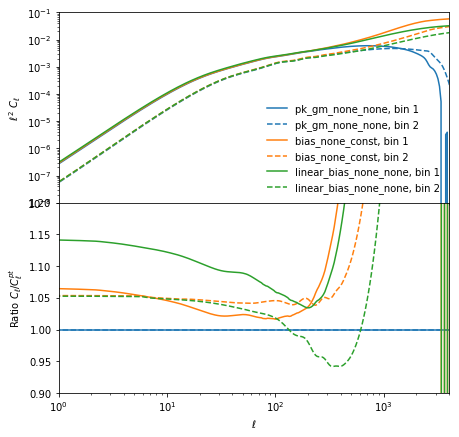

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True, squeeze=False, figsize=(7,7))
fig.subplots_adjust(hspace=0)

ls = {0 : "-", 1 : "--"}

for i, (mode, z_interpolation, k_interpolation) in enumerate(
                                              [("pk_gm", "none", "none"), 
                                               #("pk_gm", "const", "none"),
                                               #("pk_gm", "lin", "none"),
                                               #("bias", "none", "none"),
                                               ("bias", "none", "const"),
                                               #("bias", "const", "const"),
                                               ("linear_bias", "none", "none")]):
    label = f"{mode}_{z_interpolation}_{k_interpolation}"
    c = f"C{i}"
    for j, cl in enumerate(cls[label]):
        ax[0,0].loglog(ell, ell**2*cl, ls=ls[j], c=c, label=f"{label}, bin {j+1}")
        
        ax[1,0].semilogx(ell, cl/cls["pk_gm_none_none"][j], ls=ls[j], c=c, label=f"{label}, bin {j+1}")

ax[0,0].set_ylim(1e-8, 1e-1)

ax[1,0].set_ylim(0.9, 1.2)
ax[1,0].set_xlim(1, 4000)

ax[0,0].legend(frameon=False)
ax[1,0].set_xlabel(r"$\ell$")
ax[0,0].set_ylabel(r"$\ell^2\ C_\ell$")
ax[1,0].set_ylabel(r"Ratio $C_\ell/C_\ell^{pt}$")

fig.savefig("bias_comparison.png", dpi=300)

[0.2] [0.5]
[0.5] [0.75]


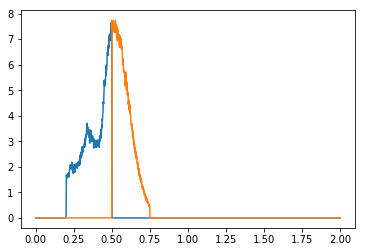

In [5]:
z, nofz = np.loadtxt("../data/BOSS/nofz/nOfZ_pdf_BOSSA_tomo0.dat", unpack=True)
plt.plot(z, nofz)
i = np.argwhere(np.diff(np.isclose(nofz,0)))
print(z[i[0]+1], z[i[1]])

z, nofz = np.loadtxt("../data/BOSS/nofz/nOfZ_pdf_BOSSA_tomo1.dat", unpack=True)
plt.plot(z, nofz)
i = np.argwhere(np.diff(np.isclose(nofz,0)))
print(z[i[0]+1], z[i[1]])


# Test BOSS wedges

In [47]:
importlib.reload(kcap.cosmosis_utils)
importlib.reload(kcap.twopoint)

sys.modules.pop("cosmosis_module", None)
sys.modules.pop("bias_module", None)
sys.modules.pop("hmx_module", None)
sys.modules.pop("halofit_module", None)

wedges = {}

window_file = os.path.join(boss_path, "../CosmoMC_BOSS/data/BOSS.DR12_windows.txt")
bands_file = os.path.join(boss_path, "../CosmoMC_BOSS/data/BOSS.DR12_rbands.txt")

cosmological_parameters = {#"omega_b" : 4.8246962797075028e-2,
                           #"omega_c" : 0.25731178759694234,
                           "ombh2" : 0.2228089E-01,
                           "omch2" : 0.1181838E+00,
                           "h0"    : 0.679565,
                           "A_s"   : 2.170229e-9,
                           "n_s"   : 0.9679701,
                           "tau"    : 0.0739,
#                            "omnuh2" : 6.4514389153979819e-4,
                            "omega_nu" : 6.4514389153979819e-4/0.679565**2,
                           "massive_nu" : 1,
                           "massless_nu" : 2.046,
                          }

bias_parameters = {"gamma" : 0.47,
                   
                   "b1_bin_1" : 0.1912671E+01,
                   "b2_bin_1" : 0.1982811E-01,
                   "gamma2_bin_1" : 1.9,
                   "gamma3_bin_1" : 0.9722212E+00,
                   "a_vir_bin_1" : 0.3884050E+01,
                  
                   "b1_bin_2" : 2.069093,
                   "b2_bin_2" : -0.08266389,
                   "gamma2_bin_2" : 1.0,
                   "gamma3_bin_2" : 1.049944,
                   "a_vir_bin_2" : 3.414406,
                  
                   "b1_bin_3" : 2.069093,
                   "b2_bin_3" : -0.08266389,
                   "gamma2_bin_3" : 1.0,
                   "gamma3_bin_3" : 1.049944,
                   "a_vir_bin_3" : 3.414406,
                }



for A_s in [1.0]:
    twopoint = kcap.twopoint.TwoPoint(probes={"pk"          : [("matter", "matter")],
                                              "wedges"      : [("galaxy", "galaxy")],
                                             },
                                      parameters={"cosmological_parameters" : cosmological_parameters,
                                                  "bias_parameters"         : bias_parameters},
                                      transfer_function="camb",
                                      nonlinear_Pk="halofit",
                                      module_paths={"CSL_PATH" : csl_path,
                                                    "BOSS_PATH" : boss_path,
                                                   },
                                      module_configs={"camb" : {"k_eta_max_scalar"  : 1000,
                                                                "high_accuracy_default" : "T",
                                                                "accuracy_boost" : 1.0,
                                                                "kmin"  : 1e-5,
                                                                "kmax"  : 8.0,
                                                                "nk"    : 215,
                                                                "mode"  : "transfer",
                                                                "zmax" : 6.0,
                                                                "nz"   : 300,
                                                                "background_zmax" : 6.0,
                                                                "background_nz"   : 6000,},
                                                      "HMx" :  {"n_k"  : 200,
                                                                "n_z"  : 100,},
                                                      "boss" : {"window_file" : window_file,
                                                                "bands_file"  : bands_file,
                                                                "z_eff"       : [0.38, 0.61],
                                                                "verbose"     : False,
                                                                "bands_range" : "20 160",
                                                                "points_range": "4 32"}},
                                      verbose=2
                                     )
    
    ini = twopoint.get_pipeline_config()
    
    wedges[A_s] = twopoint.wedges(probes=("galaxy", "galaxy"), return_bin_names=False)


COSMOSIS_SRC_DIR. Module paths assumed to be relative
to current directory,  /Users/yooken/Research/KiDS/kcap/notebooks

Parameter Priors
----------------
cosmological_parameters--ombh2        ~ delta(0.02228089)
cosmological_parameters--omch2        ~ delta(0.1181838)
cosmological_parameters--h0           ~ delta(0.679565)
cosmological_parameters--a_s          ~ delta(2.170229e-09)
cosmological_parameters--n_s          ~ delta(0.9679701)
cosmological_parameters--tau          ~ delta(0.0739)
cosmological_parameters--omega_nu     ~ delta(0.0013969941369485325)
cosmological_parameters--massive_nu   ~ delta(1)
cosmological_parameters--massless_nu  ~ delta(2.046)
bias_parameters--gamma                ~ delta(0.47)
bias_parameters--b1_bin_1             ~ delta(1.912671)
bias_parameters--b2_bin_1             ~ delta(0.01982811)
bias_parameters--gamma2_bin_1         ~ delta(1.9)
bias_parameters--gamma3_bin_1         ~ delta(0.9722212)
bias_parameters--a_vir_bin_1          ~ delta(3.88405)
bia

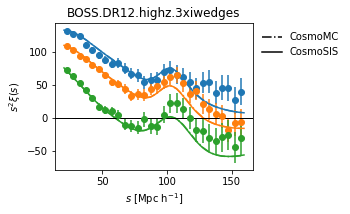

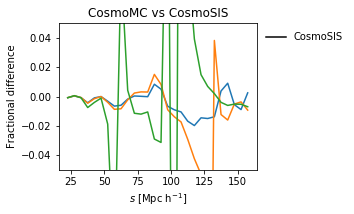

In [42]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                       figsize=(5, 3), squeeze=False)
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.7, hspace=0, wspace=0)


data = np.loadtxt(os.path.join(boss_path, "../CosmoMC_BOSS/data/BOSS.DR12.highz.3xiwedges_measurements.txt"))
cosmo_mc_y = np.loadtxt(os.path.join(boss_path, "../benchmark/vtheo_convolved.txt"))

for i in range(3):
    s = data[4:,0]
    n = len(s)
    ax[0,0].errorbar(s, s**2*data[4:,2*i+1], s**2*data[4:,2*i+2], c=f"C{i}", ls="none", marker="o")
    ax[0,0].plot(s, s**2*cosmo_mc_y[i*n:(i+1)*n], ls="-.", c=f"C{i}")

ax[0,0].plot([], [], c="k", ls="-.", label="CosmoMC")

ls = ["-", "--", ":"]

for i, (A_s, wedge) in enumerate(wedges.items()):
    y, x = wedge[0]
    ax[0,0].plot([], [], c="k", ls=ls[i], label=f"CosmoSIS")
    for j in range(3):
        ax[0,0].plot(x, x**2*y[j], c=f"C{j}", ls=ls[i])

    
ax[0,0].axhline(0, c="k", lw=1)
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

ax[0,0].set_xlabel(r"$s$ [Mpc h$^{-1}$]")
ax[0,0].set_ylabel(r"$s^2\xi(s)$")

ax[0,0].set_title("BOSS.DR12.highz.3xiwedges")

fig.savefig("../notebooks/BOSS.png")



fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                       figsize=(5, 3), squeeze=False)
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.7, hspace=0, wspace=0)


s = data[4:,0]
n = len(s)

ls = ["-", "--", ":"]

for i, (A_s, wedge) in enumerate(wedges.items()):
    y, _ = wedge[1]
    ax[0,0].plot([], [], c="k", ls=ls[i], label=f"CosmoSIS")
    for j in range(3):
        y_true = cosmo_mc_y[j*n:(j+1)*n]
        mask = np.abs(s**2*y_true) >= 0
        offset = 0#abs(min(y_true))*1.5
        ax[0,0].plot(s[mask], ((y[j]+offset)/(y_true+offset))[mask]-1, c=f"C{j}", ls=ls[i])


ax[0,0].set_ylim(-0.05, 0.05)
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

ax[0,0].set_xlabel(r"$s$ [Mpc h$^{-1}$]")
ax[0,0].set_ylabel(r"Fractional difference")

ax[0,0].set_title("CosmoMC vs CosmoSIS")

fig.savefig("../notebooks/CosmoMC_vs_CosmoSIS.png")

Text(0,0.5,'$P(k)$ [$h^{-3}$ Mpc$^{3}$]')

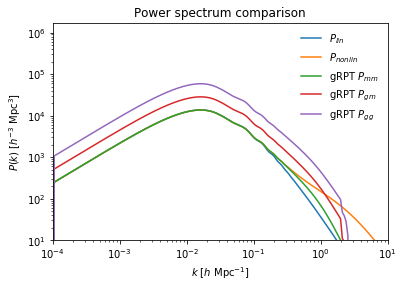

In [19]:
def pofk_interpolator(pofk, k, z=None):
    if z is None:
        intp = scipy.interpolate.InterpolatedUnivariateSpline(np.log(k), np.log(pofk))
        return lambda k: np.exp(intp(np.log(k))).squeeze()
    else:
        intp = scipy.interpolate.RectBivariateSpline(z, np.log(k), np.log(pofk))
        return lambda k, z: np.exp(intp(z, np.log(k), grid=True)).squeeze()

pofk_lin = pofk_interpolator(twopoint.data["matter_power_lin", "p_k"], twopoint.data["matter_power_lin", "k_h"], twopoint.data["matter_power_lin", "z"])
pofk_hmcode = pofk_interpolator(twopoint.data["matter_power_nl", "p_k"], twopoint.data["matter_power_nl", "k_h"], twopoint.data["matter_power_nl", "z"])
mask = twopoint.data["xi_wedges", "Pk_mm"] > 0
pofk_grpt = pofk_interpolator(twopoint.data["xi_wedges", "Pk_mm"][mask], twopoint.data["matter_power_lin", "k_h"][mask])

plt.loglog(twopoint.data["matter_power_lin", "k_h"], 
           pofk_lin(twopoint.data["matter_power_lin", "k_h"], 0.61),
           label=r"$P_{lin}$")
plt.loglog(twopoint.data["matter_power_nl", "k_h"],
           pofk_hmcode(twopoint.data["matter_power_nl", "k_h"], 0.61),
           label=r"$P_{nonlin}$")
plt.loglog(twopoint.data["matter_power_lin", "k_h"], twopoint.data["xi_wedges", "Pk_mm"], label=r"gRPT $P_{mm}$")
plt.loglog(twopoint.data["matter_power_lin", "k_h"], twopoint.data["xi_wedges", "Pk_gm"], label=r"gRPT $P_{gm}$")
plt.loglog(twopoint.data["matter_power_lin", "k_h"], twopoint.data["xi_wedges", "Pk_gg"], label=r"gRPT $P_{gg}$")

plt.legend(frameon=False)
plt.ylim(ymin=1e1)
plt.xlim(1e-4, 1e1)

plt.title("Power spectrum comparison")
plt.xlabel(r"$k$ [$h$ Mpc$^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}$ Mpc$^{3}$]")


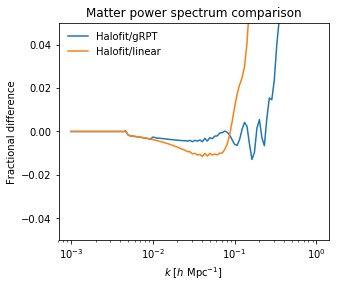

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.subplots_adjust(left=0.15)

k = np.logspace(-3, 0, 100)
ax.semilogx(k, pofk_hmcode(k, 0.61)/pofk_grpt(k) - 1, label="Halofit/gRPT")
ax.semilogx(k, pofk_hmcode(k, 0.61)/pofk_lin(k, 0.61) - 1, label="Halofit/linear")

ax.set_ylim(-0.05, 0.05)
ax.legend(frameon=False)

ax.set_title("Matter power spectrum comparison")
ax.set_xlabel(r"$k$ [$h$ Mpc$^{-1}$]")
ax.set_ylabel(r"Fractional difference")

fig.savefig("./halofit_vs_gRPT.pdf")

CMC k: 1.035956821593542e-05->7.458781029552369, (215)
CosmoSIS k: 9.999999999999997e-06->8.000000000000002, (215)


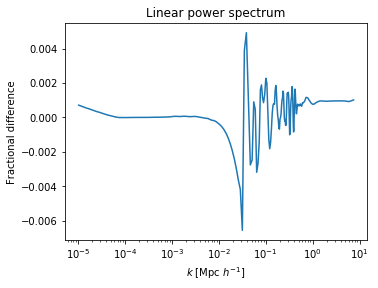

In [7]:
import scipy.interpolate

z_cmc = np.loadtxt(os.path.join(boss_path, "../benchmark/z_p_k.txt"))
k_cmc = np.exp(np.loadtxt(os.path.join(boss_path, "../benchmark/log_k_h.txt")))
pk_cmc = np.exp(np.loadtxt(os.path.join(boss_path, "../benchmark/log_p_k.txt"))).T

pk, k, z = twopoint.power_spectrum(kind="linear")

def pk_intp(log_k_intp, z_intp):
    return np.exp(scipy.interpolate.RectBivariateSpline(z, np.log(k), np.log(pk))(z_intp, log_k_intp, grid=True)).squeeze()

# plt.loglog(k, pk[0])
# plt.loglog(k_cmc, pk_cmc[0])
# plt.xlim(1e-3,1)
# plt.ylim(1e2,1e5)
plt.semilogx(k_cmc, pk_intp(np.log(k_cmc), z_cmc[-1])/pk_cmc[-1]-1)
plt.subplots_adjust(left=0.2)
plt.xlabel(r"$k$ [Mpc $h^{-1}$]")
plt.ylabel(f"Fractional difference")
plt.title("Linear power spectrum")
plt.savefig("../notebooks/p_lin_difference.png")

print(f"CMC k: {k_cmc[0]}->{k_cmc[-1]}, ({len(k_cmc)})")
print(f"CosmoSIS k: {k[0]}->{k[-1]}, ({len(k)})")

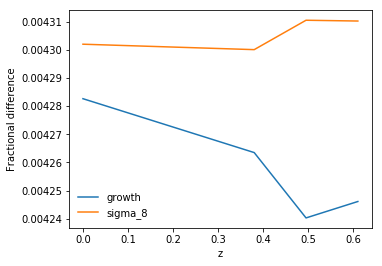

In [9]:
z_growth = twopoint.data["growth", "z"]
sigma_8_z = twopoint.data["growth", "sigma_8"]
growth_z = twopoint.data["growth", "SIGMA2_VDELTA_8"]/sigma_8_z

z_growth_cmc = np.loadtxt(os.path.join(boss_path, "../benchmark/z_growth.txt"))
growth_z_cmc = np.loadtxt(os.path.join(boss_path, "../benchmark/growth.txt"))
sigma_8_z_cmc = np.loadtxt(os.path.join(boss_path, "../benchmark/sigma8.txt"))

# plt.plot(z_growth, sigma_8_z)
# plt.plot(z_growth_cmc, sigma_8_z_cmc)

# plt.plot(z_growth, growth_z)
# plt.plot(z_growth_cmc, growth_z_cmc)

plt.plot(z_growth_cmc, scipy.interpolate.interp1d(z_growth, growth_z)(z_growth_cmc)/growth_z_cmc-1, label="growth")
plt.plot(z_growth_cmc, scipy.interpolate.interp1d(z_growth, sigma_8_z)(z_growth_cmc)/sigma_8_z_cmc-1, label="sigma_8")
plt.subplots_adjust(left=0.2)
plt.legend(frameon=False)
plt.xlabel("z")
plt.ylabel("Fractional difference")
plt.savefig("../notebooks/growth_difference.png")

## Compute predictions
Now compute the angular power spectra, correlation functions, and cosebis for the KV450 n(z) and two values of $A_s$.

In [4]:
importlib.reload(kcap.cosmosis_utils)
importlib.reload(kcap.twopoint)
        
nofz = {"shear" : ["../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.3t0.5.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.5t0.7.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.7t0.9.asc",
                   "../examples/kv450_data/nofz/B/Nz_DIR_z0.9t1.2.asc"]}

cls = {}
xis = {}
cosebis = {}

for A_s in [2.0e-9, 2.5e-9]:
    twopoint = kcap.twopoint.TwoPoint(probes={"cl"      : [("shear", "shear")],
                                              "xi"      : [("shear", "shear")],
                                              "cosebis" : [("shear", "shear")],
                                             },
                                      parameters={"cosmological_parameters" : {"A_s" : A_s}},
                                      transfer_function="camb",
                                      nofz_files=nofz,
                                      module_paths={"CSL_PATH" : csl_path,
                                                    "COSEBIS_PATH" : cosebis_path,
                                                   },
                                      module_configs={"cosebis" : {"n_max" : 5}}
                                     )
    
    ini = twopoint.get_pipeline_config()
    
    cl, ell, bin_names = twopoint.angular_power_spectrum(probes=("shear", "shear"), return_bin_names=True)
    cls[A_s] = cl
    
    xi_plus, theta = twopoint.correlation_function(probes=("shear", "shear"), kind="plus",
                                            return_bin_names=False)
    xi_minus, _ = twopoint.correlation_function(probes=("shear", "shear"), kind="minus",
                                             return_bin_names=False)
    xis[A_s] = xi_plus, xi_minus
    
    c, modes = twopoint.cosebis(probes=("shear", "shear"), return_bin_names=False)
    cosebis[A_s] = c

COSMOSIS_SRC_DIR. Module paths assumed to be relative
to current directory,  /Users/yooken/Research/KiDS/kcap/notebooks

Parameter Priors
----------------
cosmological_parameters--omega_m    ~ delta(0.3)
cosmological_parameters--h0         ~ delta(0.7)
cosmological_parameters--omega_b    ~ delta(0.05)
cosmological_parameters--tau        ~ delta(0.089)
cosmological_parameters--n_s        ~ delta(0.96)
cosmological_parameters--omega_k    ~ delta(0.0)
cosmological_parameters--w          ~ delta(-1.0)
cosmological_parameters--wa         ~ delta(0.0)
cosmological_parameters--a_s        ~ delta(2.1e-09)
halo_model_parameters--log10_theat  ~ delta(7.8)

n(z) set to histogram mode. Bin centers are 0.025000 higher than edges.
Found 5 samples and 120 bins in redshift in file ../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.3t0.5.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.5t0.7.asc ../examples/kv450_data/nofz/B/Nz_DIR_z0.7t0.9.asc ../examples/kv450_data/n

Print the configuration ("ini file") that is being used.

In [5]:
print(ini)

[DEFAULT]
hmx_path = %(KCAP_PATH)s/HMx/
csl_path = ../../cosmosis-standard-library/
cosebis_path = ../../cosebis/
kcap_path = /Users/yooken/Research/KiDS/kcap

[runtime]
sampler = 

[pipeline]
values = 
priors = 
likelihoods = 
extra_output = 
quiet = T
timing = F
debug = F
modules = consistency camb HMx load_nofz projection cl2xi cosebis

[consistency]
file = %(CSL_PATH)s/utility/consistency/consistency_interface.py

[camb]
file = %(CSL_PATH)s/boltzmann/camb/camb.so
mode = all
lmax = 2500
feedback = 0
zmax = 6.0
nz = 100
background_zmax = 6.0
background_nz = 600

[HMx]
file = %(HMX_PATH)s/lib/cosmosis_interface.so
fields = matter
nk = 128
kmin = 0.001
kmax = 10.0
nz = 32
zmin = 0.0
zmax = 5.999
verbose = 0
dimensionless_power_spectrum = 0
p_lin_source = external
matter_matter_section_name = matter_power_nl
hm_mode = hmx
one_parameter_hmcode = F
ihm = 18

[load_nofz]
file = %(CSL_PATH)s/number_density/load_nz/load_nz.py
filepath = ../examples/kv450_data/nofz/B/Nz_DIR_z0.1t0.3.asc ../ex

## Make plots

Text(0.5,0.98,'Angular power spectra')

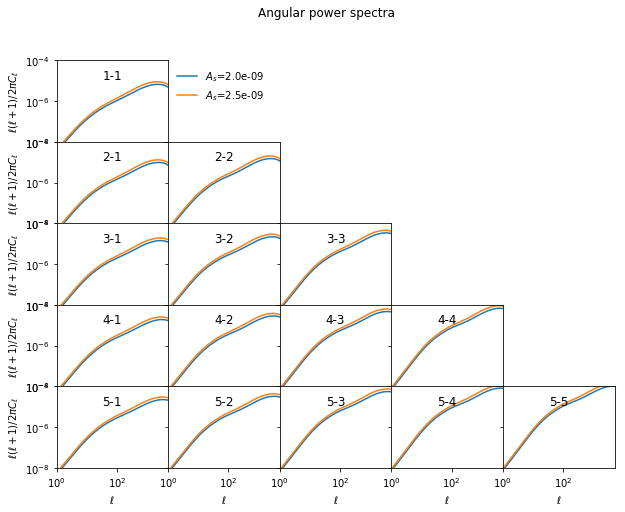

In [6]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True,
                       figsize=(2*n_z_bin, 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

u = ell*(ell+1)/(2*pi)

for A_s, tomo_cl in cls.items():
    for cl, bin_name in zip(tomo_cl, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(ell, u*cl, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title("{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$\ell$")
        if j == 0:
            ax[i,j].set_ylabel(r"$\ell(\ell+1)/2\pi C_\ell$")
        if i != j:
            ax[j,i].axis("off")

            
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

for p in ax.flat:
    p.set_xscale("log")
    p.set_yscale("log")
    p.set_xlim(1, 5000)
    p.set_ylim(1e-8, 1e-4)
    
fig.suptitle("Angular power spectra")

Text(0.5,0.98,'Correlation functions')

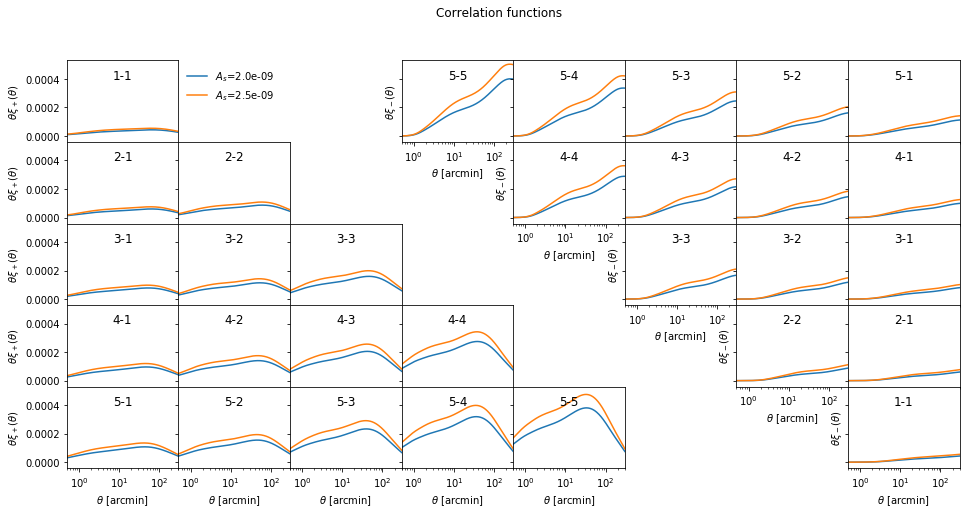

In [7]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin+3, sharex=False, sharey=True,
                       figsize=(2*(n_z_bin+3), 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

theta_arcmin = theta*180/pi*60

u = theta_arcmin

for A_s, (tomo_xi_plus, tomo_xi_minus) in xis.items():
    for xi, bin_name in zip(tomo_xi_plus, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(theta_arcmin, u*xi, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title(r"{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$\theta$ [arcmin]")
        if j == 0:
            ax[i,j].set_ylabel(r"$\theta\xi_+(\theta)$")
            
    for xi, bin_name in zip(tomo_xi_minus, bin_names):
        i, j = int(bin_name[0]), int(bin_name[1])
        ax[-i,-j].plot(theta_arcmin, u*xi, label=f"$A_s$={A_s:.1e}")
        ax[-i,-j].set_title(r"{}-{}".format(*bin_name), y=0.7)
        if i == j:
            ax[-i,-j].set_xlabel(r"$\theta$ [arcmin]")
            ax[-i,-j].set_ylabel(r"$\theta\xi_-(\theta)$")
        

for i in range(n_z_bin):
    ax[i,i+1].axis("off")
    ax[i,i+2].axis("off")
    
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

for p in ax.flat:
    p.set_xscale("log")
#     p.set_yscale("log")
    p.set_xlim(0.5, 300)
#     p.set_ylim(1e-5, 1e-3)

fig.suptitle("Correlation functions")

Text(0.5,0.98,'COSEBIS')

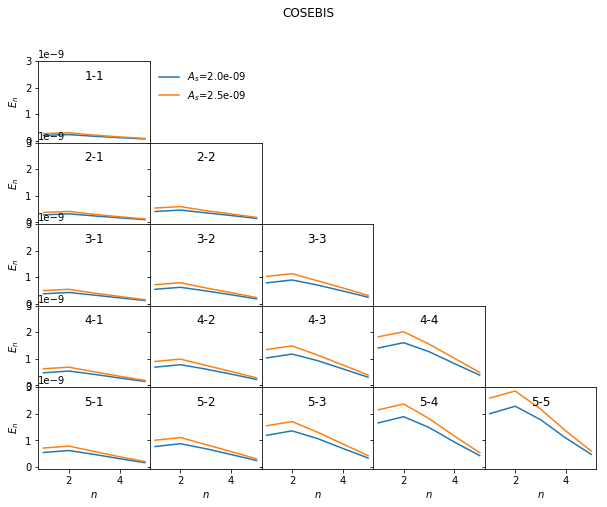

In [8]:
n_z_bin = len(nofz["shear"])

fig, ax = plt.subplots(n_z_bin, n_z_bin, sharex=True, sharey=True,
                       figsize=(2*n_z_bin, 1.5*n_z_bin))
fig.subplots_adjust(hspace=0, wspace=0)

u = 1

for A_s, tomo_cosebis in cosebis.items():
    for c, bin_name in zip(tomo_cosebis, bin_names):
        i, j = int(bin_name[0])-1, int(bin_name[1])-1
        ax[i,j].plot(modes, c, label=f"$A_s$={A_s:.1e}")
        ax[i,j].set_title("{}-{}".format(*bin_name), y=0.7)
        if i == n_z_bin-1:
            ax[i,j].set_xlabel(r"$n$")
        if j == 0:
            ax[i,j].set_ylabel(r"$E_n$")
        if i != j:
            ax[j,i].axis("off")

            
ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

# for p in ax.flat:
#     p.set_xscale("log")
#     p.set_yscale("log")
#     p.set_xlim(1, 5000)
#     p.set_ylim(1e-8, 1e-4)

fig.suptitle("COSEBIS")